In this problem we will be implementing components of iLQR and Gain Scheduled LQR.

In [20]:
# Package Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are
from __future__ import annotations
from typing import Callable, Optional
import urllib.request

base_url = "https://github.com/PrinciplesofRobotAutonomy/AA274A_midterm_FA25/raw/main/data/"
files = ["real_model_blind.npz"]

for file in files:
    url = base_url + file
    urllib.request.urlretrieve(url, file)
    print(f"Downloaded {file}")

Downloaded real_model_blind.npz


In [21]:
# Constants
m = 1.0
g = 9.81
ell = 0.25
Izz = 0.025
dt_default = 0.02
T_hov = m * g / 2.0

# Cost weights
q_p = 10.0
q_v = 2.0
q_phi = 5.0
q_omega = 1.0

##### CHANGE FOR PART D ######
r_T = 1e-3

goal = np.array([1.5, 0.0, 1.0, 0.0, 0.0, 0.0])
hover_u = np.array([T_hov, T_hov])

# Helper Functions

In [22]:
class RealWorld:
    """
    RealWorld(dt, path="data/real_model_blind.npz", seed=274)

    Produces a function f_real_step(x, u, t) that:
      1) adds tiny command jitter to u (optional)
      2) applies hidden per-rotor thrust scaling
      3) advances state with the *nominal* f_discrete(x, u_scaled, dt)
      4) injects hidden accel biases into (vx, vy) via a post-step delta

    The binary blob contains:
      - scale_T: (2,) multiplicative thrust scales [alpha1, alpha2]
      - drift_mg: (2,) (kept for future; not used directly with pure discrete stepping)
      - geom: (2,) (kept for future; not used directly with pure discrete stepping)
      - bias_axay: (T, 2) per-step acceleration biases in (ax, ay)
      - noise_u: (T, 2) optional tiny control noise per step
    """

    def __init__(self, dt: float, path: str = "data/real_model_blind.npz", seed: int = 274):
        self.dt = float(dt)
        self.rng = np.random.default_rng(seed)
        blob = np.load(path)

        # Required keys (opaque to students)
        self.scale_T   = np.asarray(blob["scale_T"], dtype=float)        # (2,)
        self.bias_axay = np.asarray(blob["bias_axay"], dtype=float)      # (T, 2)

        # Optional/legacy keys (loaded but not required for the discrete wrapper)
        self.noise_u   = np.asarray(blob["noise_u"], dtype=float) if "noise_u" in blob else None
        self.drift_mg  = np.asarray(blob.get("drift_mg", [1.0, 1.0]), dtype=float)
        self.geom      = np.asarray(blob.get("geom", [0.25, 0.025]), dtype=float)

        self._T = self.bias_axay.shape[0]

    def make_step(self, f_discrete_nominal: Callable[[np.ndarray, np.ndarray, float], np.ndarray]
                 ) -> Callable[[np.ndarray, np.ndarray, int], np.ndarray]:
        """
        Returns: f_real_step(x, u_cmd, t) -> x_{t+1} under hidden 'real' effects,
                 using ONLY the nominal f_discrete_nominal call internally.
        """

        alpha1, alpha2 = float(self.scale_T[0]), float(self.scale_T[1])
        dt = self.dt

        def f_real_step(x: np.ndarray, u_cmd: np.ndarray, t: int) -> np.ndarray:
            # 1) tiny command jitter (if provided)
            u = u_cmd.copy()
            if self.noise_u is not None and 0 <= t < self.noise_u.shape[0]:
                u = u + self.noise_u[t]

            # 2) hidden per-rotor thrust scale (actuator miscalibration)
            #    works for any 2D input of the thrust pair [T1, T2]
            u_scaled = u.copy()
            u_scaled[0] = alpha1 * u_scaled[0]
            u_scaled[1] = alpha2 * u_scaled[1]

            # 3) advance one step via nominal discrete dynamics
            x_next = f_discrete_nominal(x, u_scaled, dt)

            # 4) inject hidden acceleration biases by nudging velocities
            #    v_{x,y}(t+1) += dt * a_bias(t)
            if t < self._T:
                ax_bias, ay_bias = self.bias_axay[t]
            else:
                ax_bias, ay_bias = self.bias_axay[-1]  # hold last value
            x_next = x_next.copy()
            x_next[1] += dt * float(ax_bias)  # vx
            x_next[3] += dt * float(ay_bias)  # vy

            return x_next

        return f_real_step


def plot_planar_trajectory(X_ilqr, X_gslqr=None, goal=(1.5, 1.0)):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5))
    plt.plot(X_ilqr[:,0], X_ilqr[:,2], '-r', lw=2, label="iLQR trajectory")
    if X_gslqr is not None:
        plt.plot(X_gslqr[:,0], X_gslqr[:,2], '-b', lw=2, label="GS-LQR trajectory")
    plt.scatter([0, goal[0]], [0, goal[1]], c=['k','g'], marker='x', s=80, label="Start / Goal")
    plt.axis("equal")
    plt.xlabel("$p_x$ (m)")
    plt.ylabel("$p_y$ (m)")
    plt.title("Planar Trajectories")
    plt.legend()
    plt.tight_layout()
    plt.show()

def rollout_cost(X, U):
    J = 0.0
    Q  = np.diag([10.0, 2.0, 10.0, 2.0, 5.0, 1.0])
    R  = np.diag([1e-3, 1e-3])
    Qf = Q  # keeps the comparison neutral and consistent with your iLQR demo
    x_star = np.array([1.5, 0.0, 1.0, 0.0, 0.0, 0.0])
    u_star = np.array([T_hov, T_hov])

    for t in range(U.shape[0]):
        dx = X[t] - x_star
        du = U[t] - u_star
        J += dx @ Q @ dx + du @ R @ du
    dxT = X[-1] - x_star
    J += dxT @ Qf @ dxT
    return float(J)

def plot_time_series(X, U, dt, title=""):
    import matplotlib.pyplot as plt
    tX = np.arange(X.shape[0]) * dt     # length T+1
    tU = np.arange(U.shape[0]) * dt     # length T

    fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=False)
    axs[0].plot(tX, X[:, 0], label="p_x")
    axs[0].plot(tX, X[:, 2], label="p_y")
    axs[0].set_ylabel("position (m)"); axs[0].legend()

    axs[1].plot(tX, X[:, 4] * 180 / np.pi, label="phi (deg)")
    axs[1].set_ylabel("attitude (deg)"); axs[1].legend()

    axs[2].plot(tU, U[:, 0], label="T1")
    axs[2].plot(tU, U[:, 1], label="T2")
    axs[2].set_ylabel("thrust (N)"); axs[2].set_xlabel("time (s)"); axs[2].legend()

    fig.suptitle(title); plt.tight_layout()

def dlqr_infinite_horizon(A, B, Q, R):
    """
    Solve the infinite-horizon discrete-time LQR problem.
        minimize sum (x'Qx + u'Ru)
        subject to x_{t+1} = A x_t + B u_t
    Returns:
        K: feedback gain (u = -Kx)
        S: solution to discrete algebraic Riccati equation
    """
    S = solve_discrete_are(A, B, Q, R)
    K = np.linalg.inv(B.T @ S @ B + R) @ (B.T @ S @ A)
    return K, S

def minjerk_poly(x0, xf, tf, tvec):
    """Return position, velocity, acceleration along a 1D minimum-jerk trajectory."""
    # normalized time
    s = np.clip(tvec / tf, 0, 1)
    s2 = s*s; s3 = s2*s; s4 = s3*s; s5 = s4*s
    # poly
    p = x0 + (xf - x0) * (10*s3 - 15*s4 + 6*s5)
    v = (xf - x0) * (30*s2 - 60*s3 + 30*s4) / tf
    a = (xf - x0) * (60*s - 180*s2 + 120*s3) / (tf**2)
    return p, v, a

def build_reference(T=150):
    tf = T * dt_default
    t = np.linspace(0, tf, T+1)
    px, vx, ax = minjerk_poly(0, 1.5, tf, t)
    py, vy, ay = minjerk_poly(0, 1.0, tf, t)

    Tsum = np.sqrt((ay + 9.81)**2 + (ax)**2)
    phi_ref = np.arctan2(-ax, ay + 9.81)

    xref = np.stack([px, vx, py, vy, phi_ref, np.zeros_like(phi_ref)], axis=1)
    uref = np.stack([Tsum/2, Tsum/2], axis=1)
    return xref, uref

# Midterm Questions

Part a.) Implement the dynamics functions

In [23]:
def f_continuous(x, u):
    ######################################################################
    ######################### YOUR CODE HERE #############################
    # Write the continuous dynamics for the planar drone
    T1, T2 = u
    px, vx, py, vy, phi, omega = x
    thrust_sum = T1 + T2
    dx = np.zeros_like(x, dtype=float)
    dx[0] = vx
    dx[1] = -(thrust_sum / m) * np.sin(phi)
    dx[2] = vy
    dx[3] = (thrust_sum / m) * np.cos(phi) - g
    dx[4] = omega
    dx[5] = ((T2 - T1) * ell) / Izz
    ######################################################################
    return dx

def f_discrete(x, u, dt=dt_default):
    ######################################################################
    ######################### YOUR CODE HERE #############################
    # Write the discrete dynamics for the planar drone
    dx = x + dt * f_continuous(x, u)
    ######################################################################
    return dx

Part b.) Implement the per-timestep running cost

In [24]:
def running_cost(x, u):
  px, vx, py, vy, phi, omega = x
  T1, T2 = u
  ex = px - goal[0]
  ey = py - goal[2]
  cost = (
    q_p * ex**2 +
    q_v * vx**2 +
    q_p * ey**2 +
    q_v * vy**2 +
    q_phi * phi**2 +
    q_omega * omega**2 +
    r_T * ((T1 - T_hov)**2 + (T2 - T_hov)**2)
  )
  return cost


Part c.) Implement the continuous and discrete time Jacobian functions and use them to implement the linearize about function.

In [25]:
def continuous_jacobians(x, u):
    px, vx, py, vy, phi, omega = x
    T1, T2 = u
    A_c = np.zeros((6, 6))
    B_c = np.zeros((6, 2))

    ######################################################################
    ######################### YOUR CODE HERE #############################
    A_c[0, 1] = 1.0
    A_c[1, 4] = -((T1 + T2) / m) * np.cos(phi)
    A_c[2, 3] = 1.0
    A_c[3, 4] = -((T1 + T2) / m) * np.sin(phi)
    A_c[4, 5] = 1.0

    B_c[1, 0] = -np.sin(phi) / m
    B_c[1, 1] = -np.sin(phi) / m
    B_c[3, 0] = np.cos(phi) / m
    B_c[3, 1] = np.cos(phi) / m
    B_c[5, 0] = -ell / Izz
    B_c[5, 1] = ell / Izz
    ######################################################################

    return A_c, B_c


In [26]:
def discrete_jacobians(A_c, B_c, dt):
    ######################################################################
    ######################### YOUR CODE HERE #############################
    state_dim = A_c.shape[0]
    A_t = np.eye(state_dim) + dt * A_c
    B_t = dt * B_c
    ######################################################################

    return A_t, B_t


In [27]:
def linearize_about(x_ref, u_ref, dt=dt_default):
    """
    Affine first-order discrete-time expansion about (x_ref, u_ref):
        x_ref{t+1} ~= f_d(x_ref,u_ref) + A_t (x_ref) + B_t (u_ref)
    """
    A_c, B_c = continuous_jacobians(x_ref, u_ref)
    ######################################################################
    ######################### YOUR CODE HERE #############################
    A_t, B_t = discrete_jacobians(A_c, B_c, dt)
    x_next_ref = f_discrete(x_ref, u_ref, dt)
    ######################################################################

    return A_t, B_t, x_next_ref


# iLQR Results (Run and Discuss Results)

iLQR closed-loop rollout cost estimate: 181377.48279748726


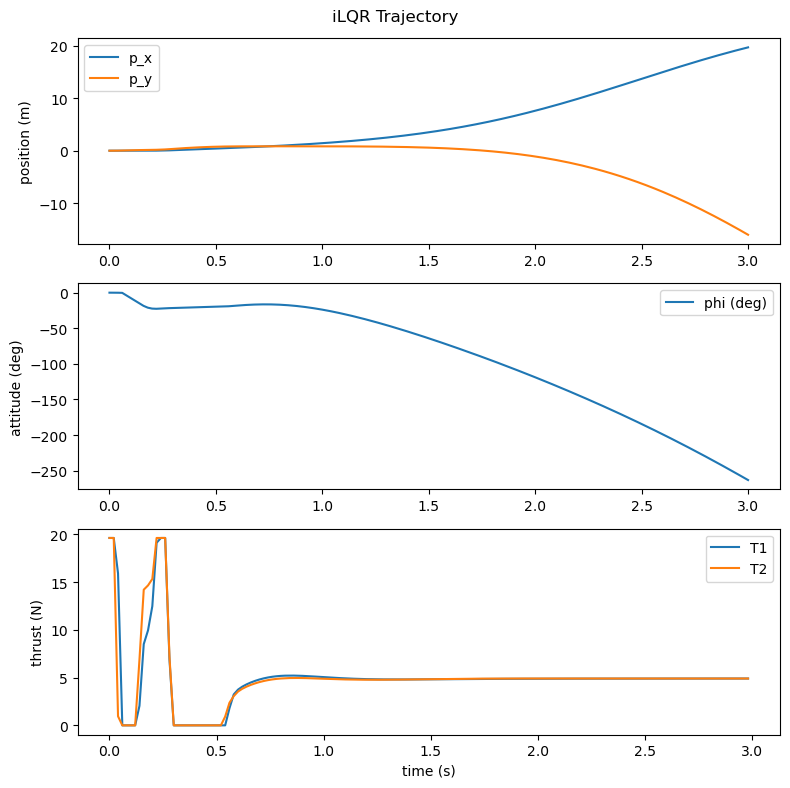

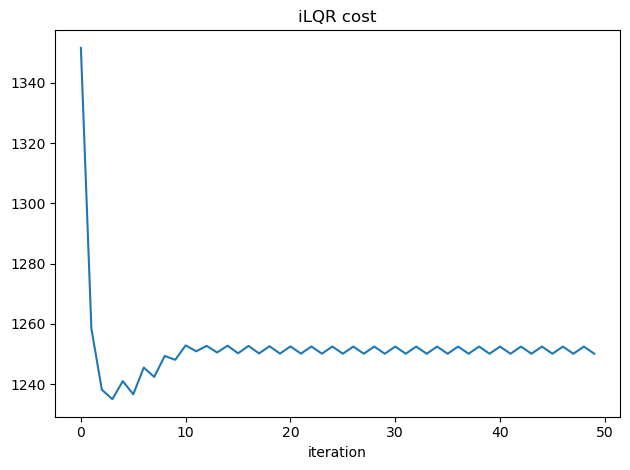

In [28]:
np.set_printoptions(precision=4, suppress=True)

def ilqr(x0, U0, T=150, max_iter=50, tol=1e-4, u_min=0.0, u_max=2*2*9.81/2):
    """
    Minimal iLQR, fixed horizon T.
    Cost is sum of running_cost; no explicit terminal cost here.
    """
    n = x0.size
    m = U0.shape[1]
    U = U0.copy()
    X = np.zeros((T+1, n))
    X[0] = x0

    def rollout(X, U):
        for t in range(T):
            u = np.clip(U[t], u_min, u_max)
            X[t+1] = f_discrete(X[t], u, dt_default)
        return X

    X = rollout(X, U)

    # quadratic cost derivatives (exact for quadratic running_cost):
    Qx = lambda x: np.array([
        2*10*(x[0]-goal[0]),
        2*2*x[1],
        2*10*(x[2]-goal[2]),
        2*2*x[3],
        2*5*x[4],
        2*1*x[5]
    ])
    Qu = lambda u: np.array([
        2*1e-3*(u[0]-T_hov),
        2*1e-3*(u[1]-T_hov)
    ])
    Qxx = np.diag([2*10, 2*2, 2*10, 2*2, 2*5, 2*1])
    Quu = np.diag([2*1e-3, 2*1e-3])
    Qux = np.zeros((m, n))

    costs = []

    for it in range(max_iter):
        # backward pass
        Vx = Qx(X[-1])
        Vxx = Qxx.copy()
        K = np.zeros((T, m, n))
        k = np.zeros((T, m))

        for t in reversed(range(T)):
            At, Bt, _ = linearize_about(X[t], U[t])
            # Q-function quadratic approx
            Qx_t = Qx(X[t]) + At.T @ Vx
            Qu_t = Qu(U[t]) + Bt.T @ Vx
            Qxx_t = Qxx + At.T @ Vxx @ At
            Quu_t = Quu + Bt.T @ Vxx @ Bt
            Qux_t = Qux + Bt.T @ Vxx @ At

            # regularization (tiny) to avoid singular Quu
            Quu_reg = Quu_t + 1e-9*np.eye(m)
            K[t] = -np.linalg.solve(Quu_reg, Qux_t)
            k[t] = -np.linalg.solve(Quu_reg, Qu_t)

            Vx = Qx_t + K[t].T @ Quu_t @ k[t] + K[t].T @ Qu_t + Qux_t.T @ k[t]
            Vxx = Qxx_t + K[t].T @ Quu_t @ K[t] + K[t].T @ Qux_t + Qux_t.T @ K[t]
            Vxx = 0.5 * (Vxx + Vxx.T)  # symmetrize

        # forward rollout
        X_new = np.zeros_like(X)
        U_new = np.zeros_like(U)
        X_new[0] = X[0]
        J = 0.0
        for t in range(T):
            du = k[t] + K[t] @ (X_new[t] - X[t])
            U_new[t] = np.clip(U[t] + du, u_min, u_max)
            X_new[t+1] = f_discrete(X_new[t], U_new[t])
            J += running_cost(X_new[t], U_new[t])
        J += running_cost(X_new[-1], hover_u)  # mild terminal term reuse

        costs.append(J)

        # convergence check
        if it > 0:
            rel = abs(costs[-2] - costs[-1]) / max(1.0, abs(costs[-2]))
            if rel < tol:
                X, U = X_new, U_new
                break

        X, U = X_new, U_new

    return X, U, np.array(costs)

T = 150
x0 = np.zeros(6)
U0 = np.tile(hover_u, (T, 1))
X_ilqr, U, costs = ilqr(x0, U0, T=T)


rw = RealWorld(dt_default, path="data/real_model_blind.npz")
f_real_step = rw.make_step(f_discrete)

# Replay iLQR controls open-loop on real dynamics
X_ilqr_real = np.zeros_like(X_ilqr)
X_ilqr_real[0] = X_ilqr[0]
for t in range(U.shape[0]):
    X_ilqr_real[t+1] = f_real_step(X_ilqr_real[t], U[t], t)

J_total = rollout_cost(X_ilqr_real, U)
print("iLQR closed-loop rollout cost estimate:", J_total)

# plots
t = np.arange(X_ilqr_real.shape[0]) * dt_default
plot_time_series(X_ilqr_real, U, dt_default, title="iLQR Trajectory")
plt.figure(); plt.plot(costs); plt.title("iLQR cost"); plt.xlabel("iteration"); plt.tight_layout(); plt.show()

# GS-LQR Results (Run and Discuss Results)

GS-LQR closed-loop rollout cost estimate: 2132.5729393053825


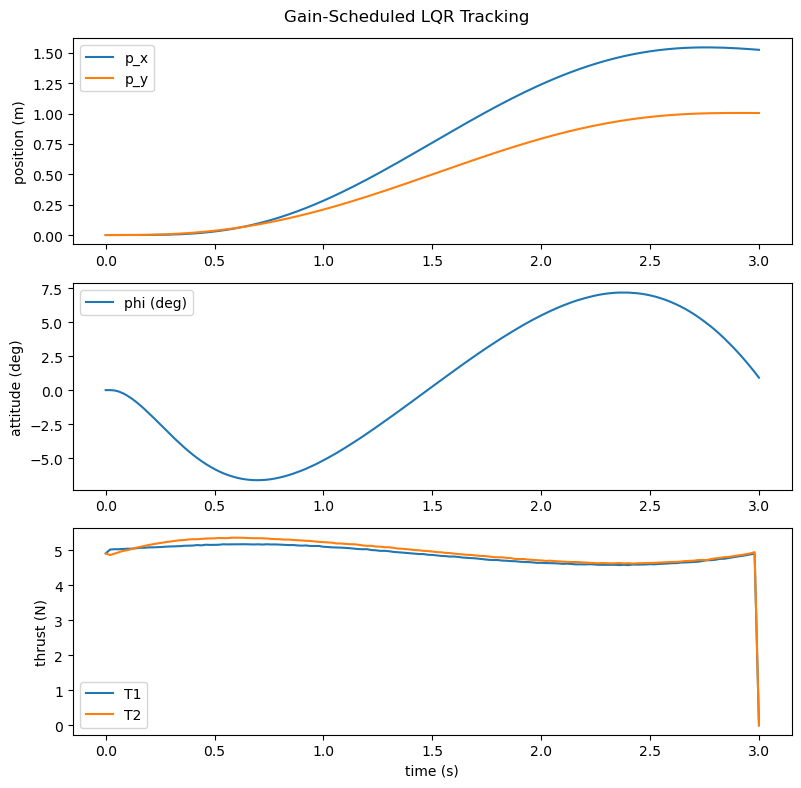

In [29]:
# Cost weights
Q = np.diag([10, 2, 10, 2, 5, 1])
R = np.diag([1e-3, 1e-3])
T = 150
xref, uref = build_reference(T)

X_gslqr = np.zeros_like(xref)
U = np.zeros_like(uref)
X_gslqr[0] = np.zeros(6)

# Outside the loop (once):
rw = RealWorld(dt_default, path="data/real_model_blind.npz")
f_real_step = rw.make_step(f_discrete)

for t in range(T):
    A_t, B_t, _ = linearize_about(xref[t], uref[t])
    # Compute infinite-horizon LQR gain
    K_t, _ = dlqr_infinite_horizon(A_t, B_t, Q, R)

    # Apply local LQR feedback law
    u_fb = -K_t @ (X_gslqr[t] - xref[t])

    U[t] = np.clip(uref[t] + u_fb, 0.0, 2*T_hov)
    X_gslqr[t+1] = f_real_step(X_gslqr[t], U[t], t)

J_total = rollout_cost(X_gslqr, U)
print("GS-LQR closed-loop rollout cost estimate:", J_total)

tvec = np.arange(T+1) * dt_default
plot_time_series(X_gslqr, U, dt_default, title="Gain-Scheduled LQR Tracking")
plt.show()

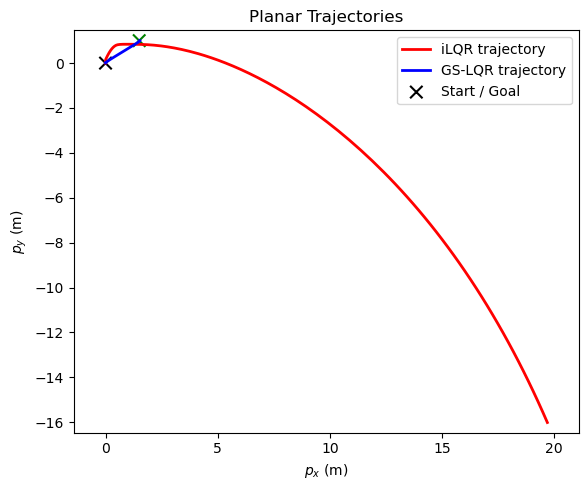

In [30]:
# Comparison of the closed loop trajectories
plot_planar_trajectory(X_ilqr_real, X_gslqr, goal=(1.5,1.0))